In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import sys

# 물질 설정 및 Refractive Index 설정
mp.verbosity(0)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

In [2]:
resolution = 10 

design_region_width = 4 
design_region_height = 2 
pml_size = 1.0 


Sx = 2 * pml_size + design_region_width 
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

In [3]:

wavelengths = np.array([1.5, 1.55, 1.6])

frequencies = 1/wavelengths
nf = len(frequencies) 

minimum_length = 0.09 
eta_i = 0.5  
eta_e = 0.55  
eta_d = 1 - eta_e  
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen

In [4]:
source_center = [0, -(design_region_height / 2 + 1.5), 0] # Source 위치
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

In [5]:
# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

# filter.py conic_filter 함수와 simple_2d_filter 함수를 사용
def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    # 출력값 -1 ~ 1으로 제한
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

In [6]:

# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

In [7]:

# Meep simulation 세팅
sim = mp.Simulation(
    cell_size=cell_size, # cell_size = mp.Vector3(Sx, Sy)
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

In [8]:
monitor_position, monitor_size = mp.Vector3(0,design_region_height/2+1.5), mp.Vector3(0.01,0) 
FourierFields = mpa.FourierFields(
    sim,mp.Volume(center=monitor_position,size=monitor_size),
    mp.Ez,yee_grid=True)
ob_list = [FourierFields]

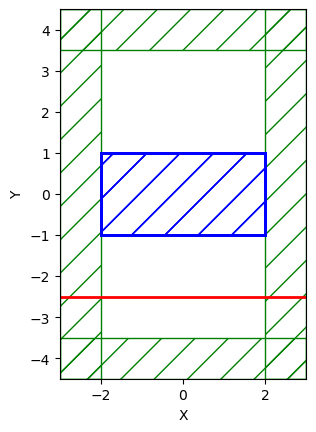

In [9]:
#def J(fields):
#    return npa.mean(npa.abs(fields[:,1]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

def J_0(fields):
    return npa.mean(npa.abs(fields[0,:]) ** 2)
def J_1(fields):
    return npa.mean(npa.abs(fields[1,:]) ** 2) 
def J_2(fields):
    return npa.mean(npa.abs(fields[2,:]) ** 2) 

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0, J_1, J_2],
    #objective_functions=J
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)
opt.plot2D(True)

In [10]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    
    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

# plot 기능
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [11]:
algorithm = nlopt.LD_MMA # 어떤 알고리즘으로 최적화를 할 것인가?
# MMA : 점근선 이동

n = Nx * Ny  # number of parameters

# Initial guess - 초기 시작값 0.5
x = np.ones((n,)) * 0.5

# lower and upper bounds (상한 : 1, 하한 : 0)
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# Optimization parameter
cur_beta = 4
beta_scale = 1.5 
num_betas = 9 
update_factor = 12  # number of iterations between beta updates
ftol = 1e-5 

# for iters in range(num_betas):
#     solver = nlopt.opt(algorithm, n)
#     solver.set_lower_bounds(lb) # lower bounds
#     solver.set_upper_bounds(ub) # upper bounds
#     solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
#     # solver.set_max_objective(lambda a, g: f1(a, g, cur_beta), lambda a, g: f2(a, g, cur_beta), lambda a, g: f3(a, g, cur_beta)) # Set the objective function to be maximized
#     solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
#     solver.set_ftol_rel(ftol) # Set the relative tolerance for convergence
#     x[:] = solver.optimize(x)
#     cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration

Starting forward run...
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


Calculating gradient...


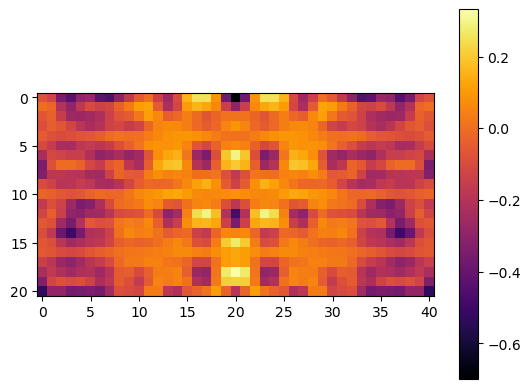

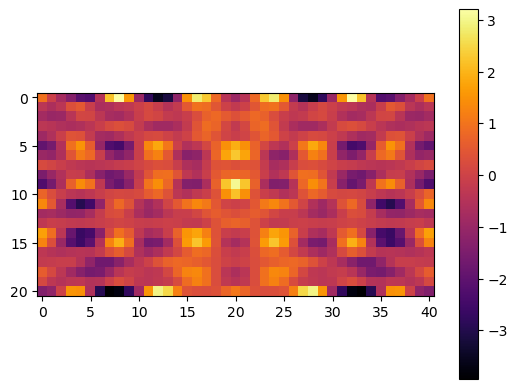

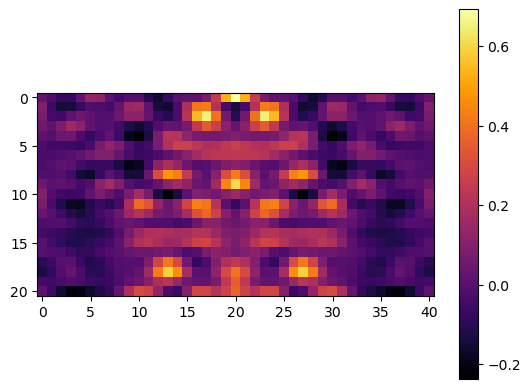

In [12]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta)], need_gradient=True)
dJ_du_0 = np.array_split(np.squeeze(dJ_du), 3)[0]
dJ_du_1 = np.array_split(np.squeeze(dJ_du), 3)[1]
dJ_du_2 = np.array_split(np.squeeze(dJ_du), 3)[2]
# print(dJ_du_0)
plt.figure()
plt.imshow(np.rot90(dJ_du_0[0,:,0].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_1[0,:,1].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_2[0,:,2].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
plt.colorbar()
#plt.savefig("adjoint_gradient_map.png")


In [13]:
db = 1e-3
choose = 861
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)
g_discrete_0 = np.squeeze(g_discrete)[:,0]
g_discrete_1 = np.squeeze(g_discrete)[:,1]
g_discrete_2 = np.squeeze(g_discrete)[:,2]
#np.savetxt('../Junjeong/Multi-freq_Opt/data/fd_gradients.txt', g_discrete)

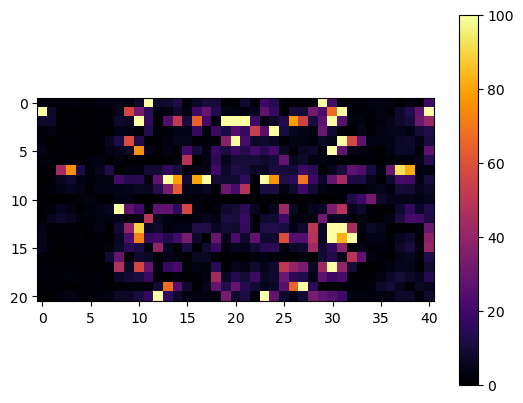

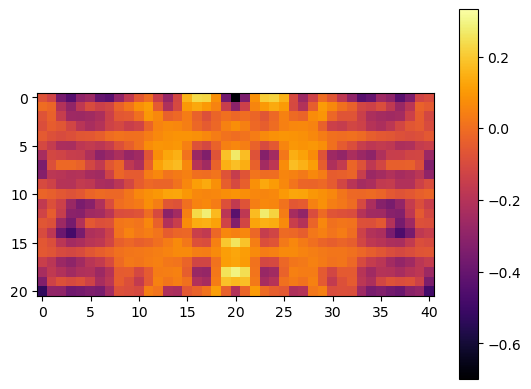

In [14]:
err_0= (np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100)
plt.imshow(np.rot90(err_0.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_0).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

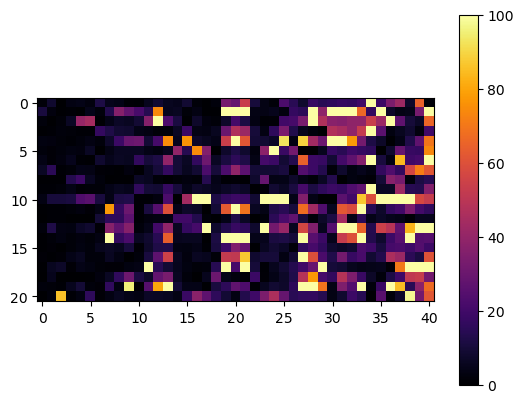

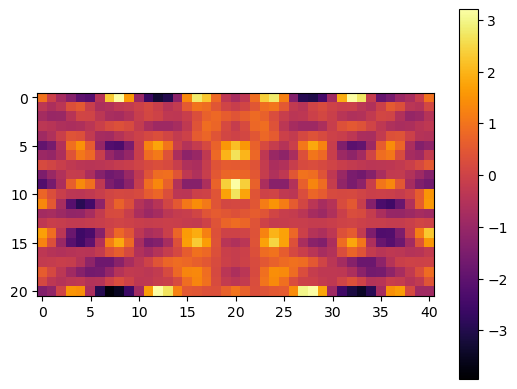

In [15]:
err_1= (np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100)
plt.imshow(np.rot90(err_1.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_1).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

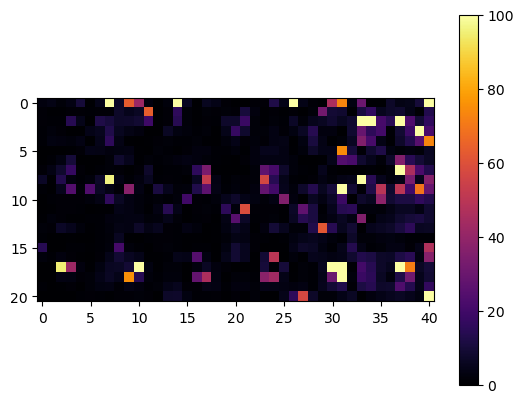

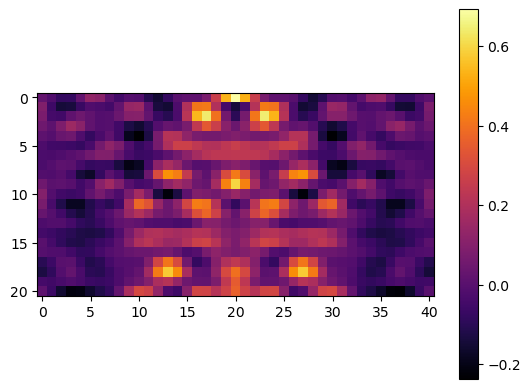

In [16]:
err_2= (np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100)
plt.imshow(np.rot90(err_2.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_2).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

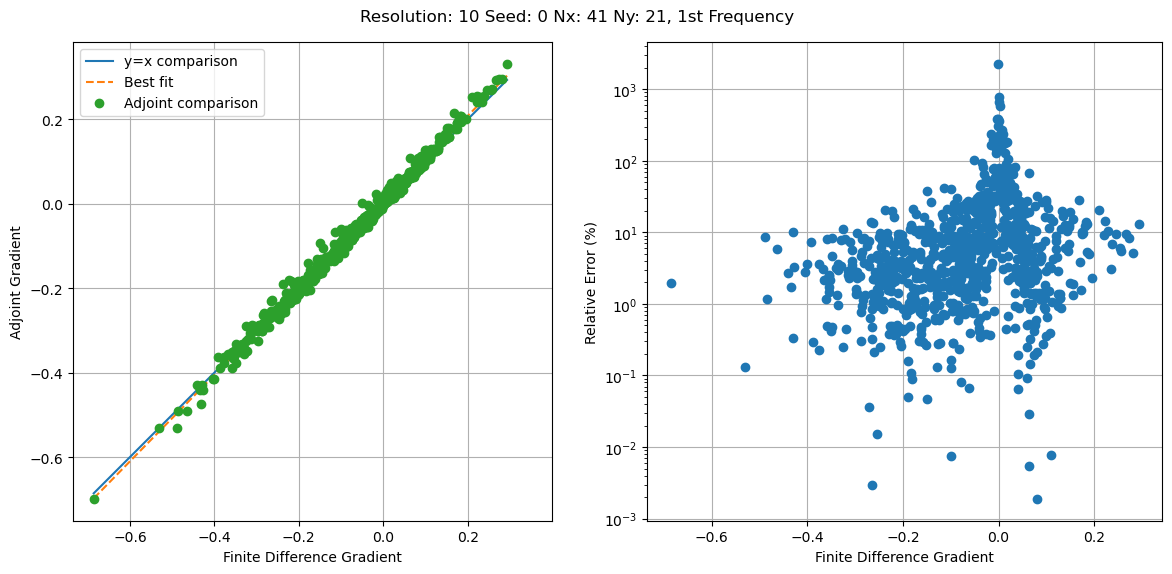

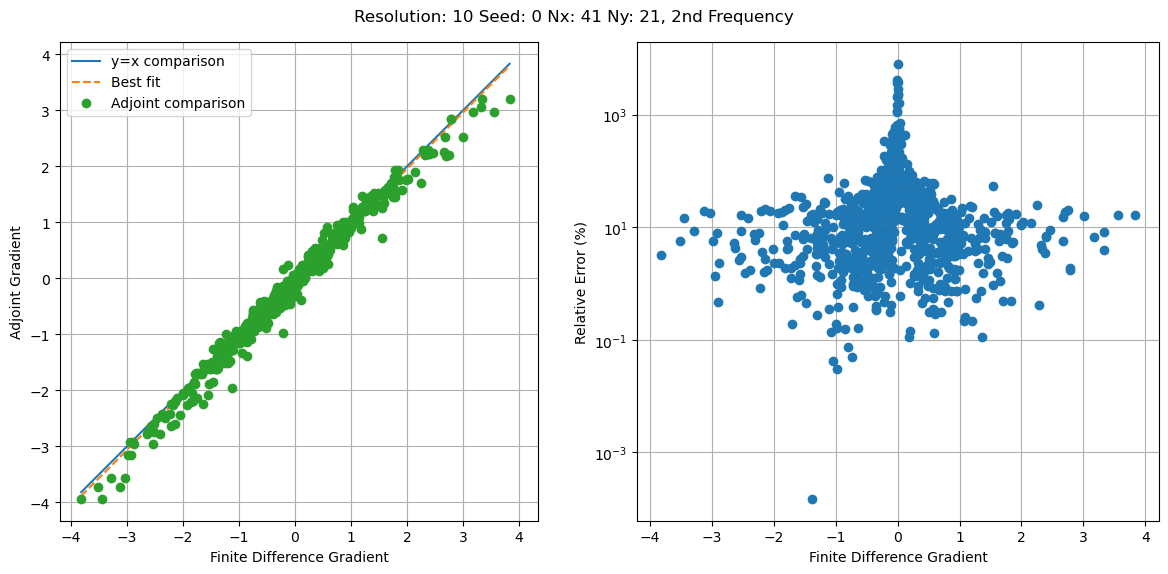

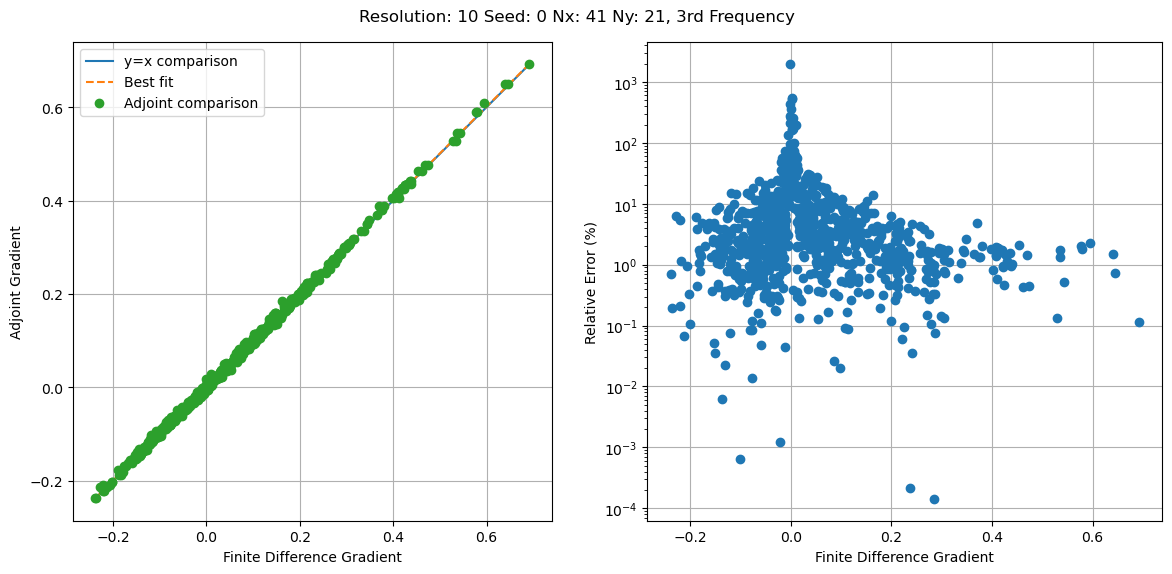

In [17]:
(m0, b0) = np.polyfit(g_discrete_0, dJ_du_0[0,idx,0], 1)
(m1, b1) = np.polyfit(g_discrete_1, dJ_du_1[0,idx,1], 1)
(m2, b2) = np.polyfit(g_discrete_2, dJ_du_2[0,idx,2], 1)

min_g_0 = np.min(g_discrete_0)
max_g_0 = np.max(g_discrete_0)
min_g_1 = np.min(g_discrete_1)
max_g_1 = np.max(g_discrete_1)
min_g_2 = np.min(g_discrete_2)
max_g_2 = np.max(g_discrete_2)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_0, max_g_0], [min_g_0, max_g_0], label="y=x comparison")
plt.plot([min_g_0, max_g_0], [m0 * min_g_0 + b0, m0 * max_g_0 + b0], "--", label="Best fit")
plt.plot(g_discrete_0, dJ_du_0[0,idx,0], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_0 = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100
)
plt.semilogy(g_discrete_0, rel_err_0, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 1st Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_1, max_g_1], [min_g_1, max_g_1], label="y=x comparison")
plt.plot([min_g_1, max_g_1], [m1 * min_g_1 + b1, m1 * max_g_1 + b1], "--", label="Best fit")
plt.plot(g_discrete_1, dJ_du_1[0,idx,1], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_1 = (
    np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100
)
plt.semilogy(g_discrete_1, rel_err_1, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 2nd Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_2, max_g_2], [min_g_2, max_g_2], label="y=x comparison")
plt.plot([min_g_2, max_g_2], [m2 * min_g_2 + b2, m2 * max_g_2 + b2], "--", label="Best fit")
plt.plot(g_discrete_2, dJ_du_2[0,idx,2], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_2 = (
    np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100
)
plt.semilogy(g_discrete_2, rel_err_2, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 3rd Frequency".format(resolution, 0, Nx, Ny))
plt.show()

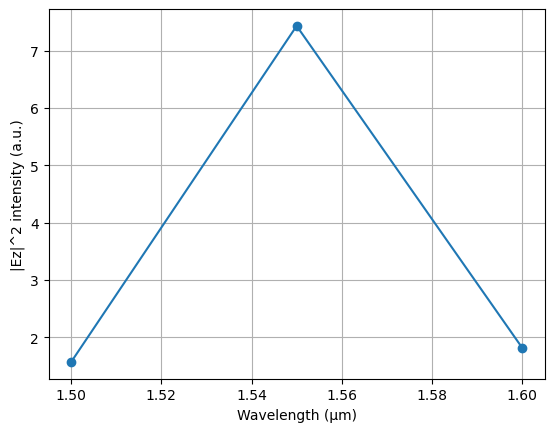

In [18]:
intensities = np.abs(opt.get_objective_arguments()[0][:,1]) ** 2

plt.figure()
plt.plot(wavelengths, intensities, "-o")
plt.grid(True)
plt.xlabel("Wavelength (μm)")
plt.ylabel("|Ez|^2 intensity (a.u.)")
plt.show()